# **Персональное кредитное предложение клиентам банка**
Датасет содержит данные о 5000 клиентах банка.

Данные включают демографическую информацию о клиенте (возраст, доход и т.д.), отношения клиента с банком (ипотека, счет ценных бумаг и т.д.) и реакцию клиента на последнюю кампанию по персональному кредитованию (бинарный признак - согласился/отказался).

Задача - построить модель определения клиентов, на которых стоит сфокусировать будущие персональные предложения кредитных продуктов.

# Импорт библиотек

In [86]:
# библиотеки для обработки и анализа структурированных данных
import numpy as np
import pandas as pd

# библиотеки визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# библиотека scikit-learn для машинного обучения
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# библиотека для работы с данными в формате JSON
import json

# библиотека почтовых индексов США
!pip install zipcodes
import zipcodes as zcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Загрузка файла и описание данных

Загружаем данные в датафрейм из CSV-файла

In [87]:
# источник https://www.kaggle.com/datasets/teertha/personal-loan-modeling
url = 'Bank_Personal_Loan.csv'
df = pd.read_csv(url)

Оценим размеры таблицы данных (строки данных, столбцы признаков)

In [88]:
df.shape

(5000, 14)

Выведем информацию о структуре таблицы

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


Выведем первые 10 строк таблицы

In [90]:
df.head(10)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
5,6,37,13,29,92121,4,0.4,2,155,0,0,0,1,0
6,7,53,27,72,91711,2,1.5,2,0,0,0,0,1,0
7,8,50,24,22,93943,1,0.3,3,0,0,0,0,0,1
8,9,35,10,81,90089,3,0.6,2,104,0,0,0,1,0
9,10,34,9,180,93023,1,8.9,3,0,1,0,0,0,0


Опишем столбцы (признаки):

* `ID` - идентификатор клиента

* `Age` - возраст клиента, полных лет

* `Experience` - стаж работы, лет

* `Income` - годовой доход клиента, тыс. долларов США

* `ZIP Code` - почтовый индекс места жительства клиента 

* `Family` - количество членов семьи клиента

* `CCAvg` - среднемесячный расход по кредитным картам, тыс. долларов США

* `Education` - уровень образования (1 - бакалавриат, 2 - магистратура, 3 - аспирантура)

* `Mortgage` - размер ипотеки, если таковая имеется, тыс. долларов США

* `Personal Loan` - принял ли этот клиент персональное предложение по кредитному продукту?

* `Securities Account` - есть ли у клиента счет ценных бумаг в банке?

* `CD Account` - есть ли у клиента депозитный сертификат (CD) на счет в банке?

* `Online` - пользуется ли клиент услугами интернет-банкинга?

* `CreditCard` - пользуется ли клиент кредитной картой, выпущенной этим банком?

Как видно, все признаки имеют числовые значения.

Признаки `ZIP Сode`, `Family`, `Education`, `Personal Loan`, `Securities Account`, `CD Account`, `Online`, `CreditCard` - категориальные, при этом признаки `Personal Loan`, `Securities Account`, `CD Account`, `Online`, `CreditCard` являются бинарными. Остальные признаки - количественные.

Целевым признаком является `Personal Loan`, таким образом возникает задача **бинарной классификации**.

In [91]:
target_col = ['Personal Loan']

# Предварительная обработка данных

## Проверка на наличие пропущенных значений

In [92]:
df.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

Как видно, ни один из признаков не имеет пропущенных значений.

Признак `ID` обозначает лишь порядковый номер элемента, очевидно не является релевантным и может быть удален.

In [93]:
df.drop(['ID'], axis=1, inplace=True)

## Обработка категориальных признаков

Для категориальных признаков `ZIP Code`, `Family`, `Education`, `Personal Loan`, `Securities Account`, `CD Account`, `Online`, `CreditCard` установим специальный категориальный тип.

In [94]:
category_col = ['ZIP Code', 'Family', 'Education', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
df[category_col] = df[category_col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   ZIP Code            5000 non-null   category
 4   Family              5000 non-null   category
 5   CCAvg               5000 non-null   float64 
 6   Education           5000 non-null   category
 7   Mortgage            5000 non-null   int64   
 8   Personal Loan       5000 non-null   category
 9   Securities Account  5000 non-null   category
 10  CD Account          5000 non-null   category
 11  Online              5000 non-null   category
 12  CreditCard          5000 non-null   category
dtypes: category(8), float64(1), int64(4)
memory usage: 260.1 KB


Проверим количество уникальных значений категориальных признаков

In [95]:
df[category_col].nunique()

ZIP Code              467
Family                  4
Education               3
Personal Loan           2
Securities Account      2
CD Account              2
Online                  2
CreditCard              2
dtype: int64

Как можно было предположить, почтовый индекс в данном случае привносит излишнюю детализацию. Имеет смысл сгруппировать данные по более крупным регионам.

In [96]:
# выберем все почтовые индексы из таблицы
zipcodes = df["ZIP Code"].unique()

# сформируем словарь индексов, соотнеся их с округами
zip_county = {}
zip_missed = [] # список не найденных индексов

# для каждого индекса ищем соответствующий ему округ,
# используя метод matching библиотеки zipcodes
# если округ не найден, оставляем индекс по умолчанию
for zipcode in zipcodes:
  county_match = zcode.matching(str(zipcode))
  if len(county_match) == 1:
    county = county_match[0].get('county')
  else:
    county = zipcode
    zip_missed.append(zipcode)
  zip_county.update({zipcode: county})

# выведем список не найденных индексов
zip_missed

[92717, 9307, 92634, 96651]

На сайте http://ru.postcode.info некоторые пропущенные индексы удалось найти. Добавим их в словарь.

In [97]:
zip_county.update({92717: 'Orange County'})
zip_county.update({92634: 'Orange County'})

Добавим новый признак `County`, соотнеся значения столбца `ZIP Code` со словарем индексов.

In [98]:
df['County'] = df['ZIP Code'].map(zip_county)

df['County'].nunique()

40

Добавим новый признак `Region`, соотнеся значения столбца `County` со словарем округов.

In [99]:
# загрузим JSON-файл областей, соответствующих округам
with open('region_county.json', 'r') as f:
  region_county = json.loads(f.read())

df['Region'] = df['County'].map(region_county)

# признаки 'ZIP Code', 'County' можно исключить
df.drop(['ZIP Code', 'County'], axis=1, inplace=True) 

# также для удобства переместим целевой признак в конец таблицы
col_names = list(df.columns)
col_names.remove(target_col[0])
df = df[col_names + target_col]

Проверим новые данные на наличие пропущенных значений.

In [100]:
df.isnull().sum()

Age                   0
Experience            0
Income                0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
Region                7
Personal Loan         0
dtype: int64

Удалим пропущенные значения.

In [101]:
df = df.dropna()

# Разведочный анализ данных (EDA)

## Категориальные признаки

In [102]:
cat_col = ['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard', 'Region', 'Personal Loan']

### Частотные диаграммы

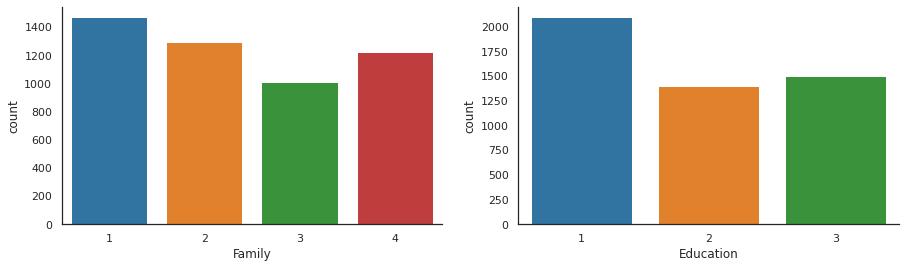

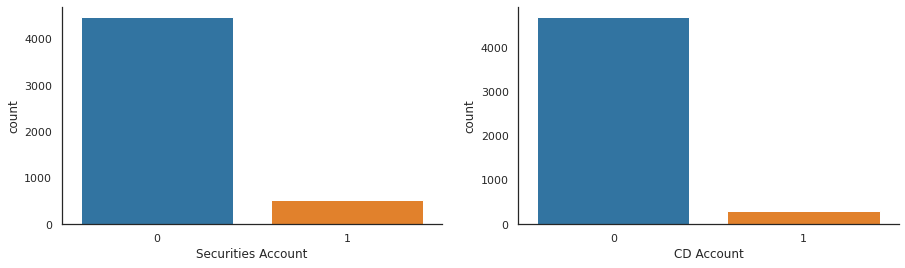

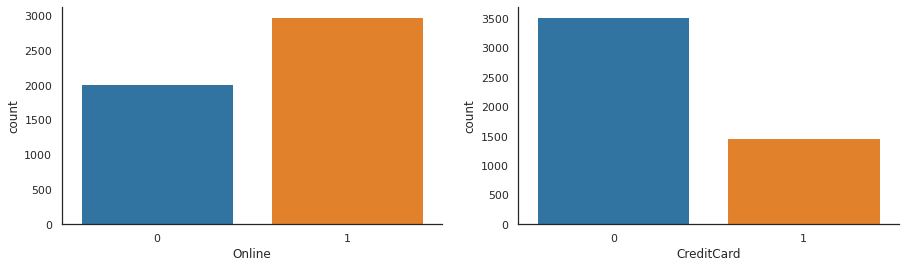

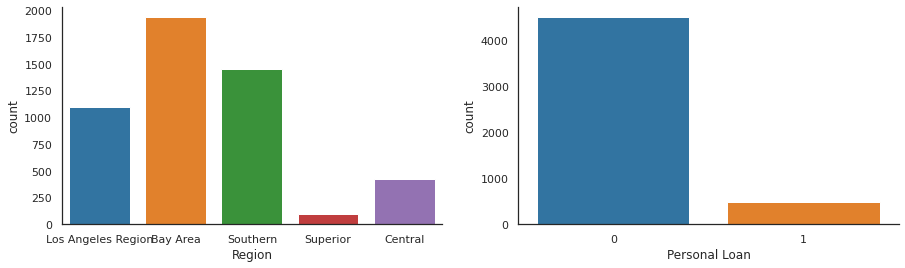

In [103]:
custom_params = {'axes.spines.right': False, 'axes.spines.top': False, 'figure.figsize': (15,4)}
sns.set_theme(style="white", rc=custom_params)
sns.set_palette(sns.color_palette("tab10"))

fig, ax = plt.subplots(1,2)
sns.countplot(x='Family', data=df, ax=ax[0])
sns.countplot(x='Education', data=df, ax=ax[1])
fig.show()

fig, ax = plt.subplots(1,2)
sns.countplot(x='Securities Account', data=df, ax=ax[0])
sns.countplot(x='CD Account', data=df, ax=ax[1])
fig.show()

fig, ax = plt.subplots(1,2)
sns.countplot(x='Online', data=df, ax=ax[0])
sns.countplot(x='CreditCard', data=df, ax=ax[1])
fig.show()

fig, ax = plt.subplots(1,2)
sns.countplot(x='Region', data=df, ax=ax[0])
sns.countplot(x='Personal Loan', data=df, ax=ax[1])
fig.show()

In [104]:
for c in cat_col:
  print(c)
  print(round(df[c].value_counts() * 100 / df[c].count(), 1))
  print('-' * 30)

Family
1    29.4
2    25.9
4    24.4
3    20.2
Name: Family, dtype: float64
------------------------------
Education
1    41.9
3    30.0
2    28.1
Name: Education, dtype: float64
------------------------------
Securities Account
0    89.5
1    10.5
Name: Securities Account, dtype: float64
------------------------------
CD Account
0    94.0
1     6.0
Name: CD Account, dtype: float64
------------------------------
Online
1    59.7
0    40.3
Name: Online, dtype: float64
------------------------------
CreditCard
0    70.6
1    29.4
Name: CreditCard, dtype: float64
------------------------------
Region
Bay Area              38.8
Southern              29.0
Los Angeles Region    21.9
Central                8.4
Superior               1.8
Name: Region, dtype: float64
------------------------------
Personal Loan
0    90.4
1     9.6
Name: Personal Loan, dtype: float64
------------------------------


Из общего числа клиентов лишь 9.6% воспользовались персональным кредитным предложением, т.е. разделение на классы является несбалансированным.

Более половины семей состоит из 1-2 человек.

Чуть более 40% клиентов имеет уровень образования - бакалавриат.

Счет ценных бумаг в банке имеют лишь около 10% клиентов.

6% клиентов имеют депозитный сертификат (CD) на счет в банке.

Почти 60% клиентов пользуются услугами онлайн-банка.

Кредитные карты банка есть примерно у 30% клиентов.



### Кросс-таблицы

Выведем диаграммы распределения клиентов, согласившихся на предложение кредита, по категориальным признакам.

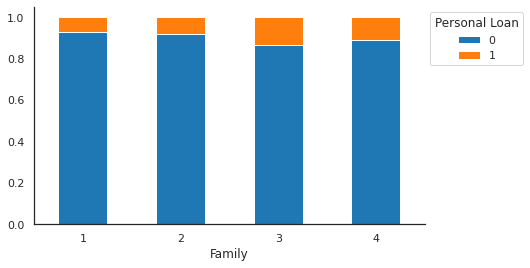

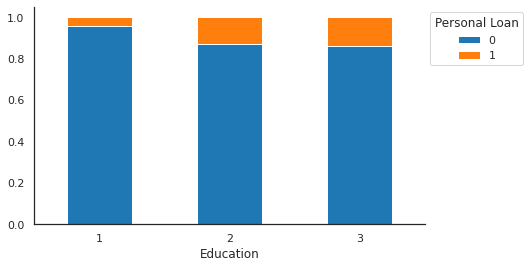

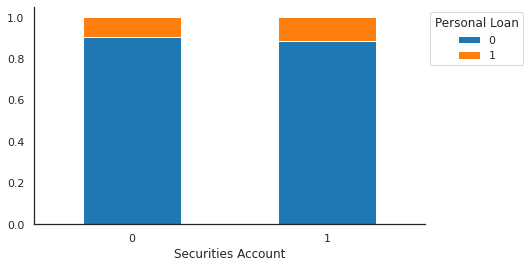

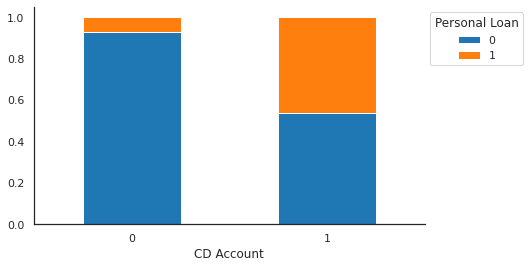

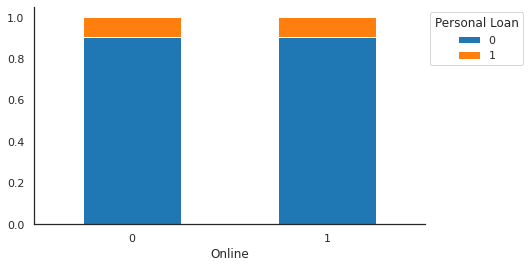

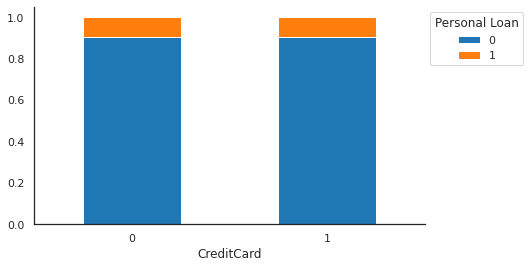

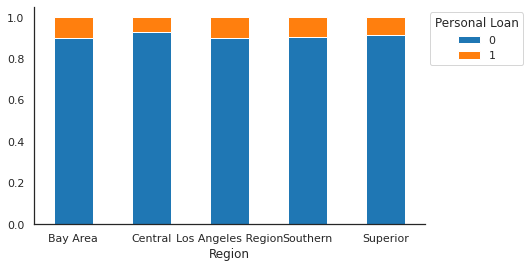

In [105]:
def cat_cross_plot(c):
  sns.set_palette(sns.color_palette("tab10"))
  tab = pd.crosstab(df[c], df['Personal Loan'], normalize='index')
  ax = tab.plot(kind='bar', stacked=True, figsize=(7,4), rot=0)
  plt.legend(title='Personal Loan', bbox_to_anchor=(1,1))
  plt.show()

custom_params = {'axes.spines.right': False, 'axes.spines.top': False, 'figure.figsize': (15,4)}
sns.set_theme(style="white", rc=custom_params)

for c in cat_col:
  if c != 'Personal Loan':
    cat_cross_plot(c)

Семьи, состоящие из 3-х и более человек, более заинтересованы в получении кредитного предложения, как и клиенты, уровень образования которых не ниже магистратуры.

Клиенты, имеющие счет ценных бумаг в банке, чуть чаще принимали кредитное предложение.

Наличие депозитного сертификата (CD) на счет в банке значительно повышает вероятность принятия кредитного предложения.

То, насколько активно клиент пользуется онлайн-банком, практически не оказывает влияние на принятие кредитного предложения, равно как и наличие кредитной карты банка.

Больший интерес к кредитному предложению проявляли клиенты из регионов LosAngeles и Bay.

## Количественные признаки

Выведем описательные характеристики.

In [106]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,4993.0,45.344883,11.461248,23.0,35.0,45.0,55.0,67.0
Experience,4993.0,20.110755,11.466277,-3.0,10.0,20.0,30.0,43.0
Income,4993.0,73.836771,46.032623,8.0,39.0,64.0,98.0,224.0
CCAvg,4993.0,1.939734,1.748169,0.0,0.7,1.5,2.5,10.0
Mortgage,4993.0,56.531744,101.762415,0.0,0.0,0.0,101.0,635.0


Возраст клиентов варьируется от 23 до 67 лет, средний возраст - 45 лет.

Минимальное значение стажа работы -3, что, по всей видимости, является ошибочным значением.

### Диаграммы рассеивания

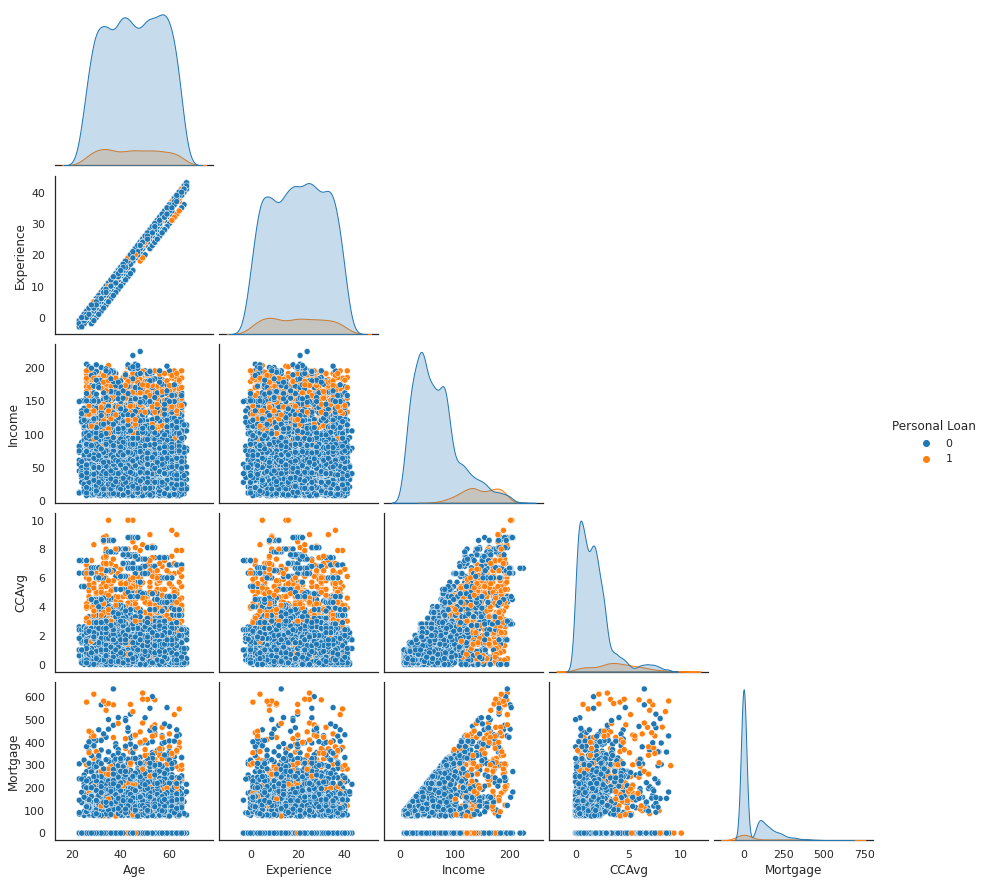

In [107]:
sns.set_palette(sns.color_palette("tab10"))
sns.pairplot(df, hue='Personal Loan', corner=True)
plt.show()

Очевидно, что признаки `Age` и `Experience` имеют сильную линейную зависимость.

Видна зависимость вероятности принятия кредитного предложения от уровня годового дохода клиента, начиная примерно от 90 тыс. долларов США.

Также среднемесячный расход по кредитным картам более 3 тыс. долларов США повышает эту вероятность.

### Матрица корреляции


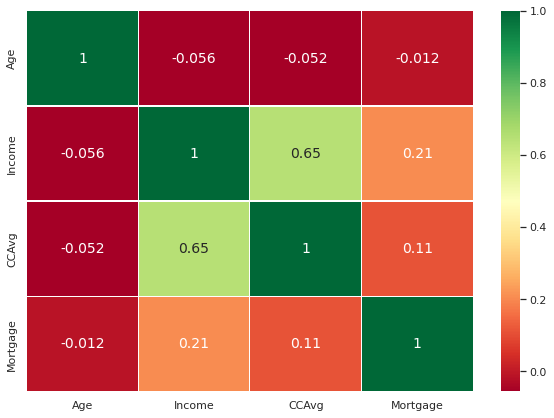

In [119]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':14});

Коллинеарность признаков `Age` и `Experience` подтверждается на диаграмме, т.о. один из них можно исключить. Поскольку признак `Experience`, как было видно выше, содержит некоторые ошибочные данные, он может быть исключен.

In [109]:
df.drop(['Experience'], axis=1, inplace=True)

## Обнаружение выбросов

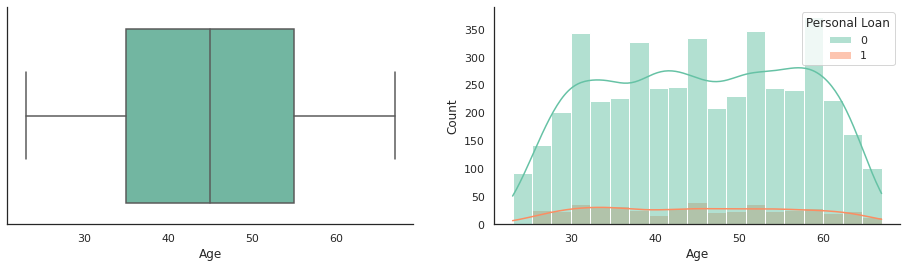

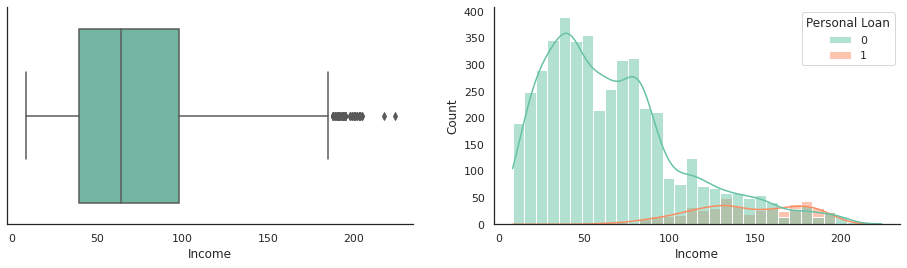

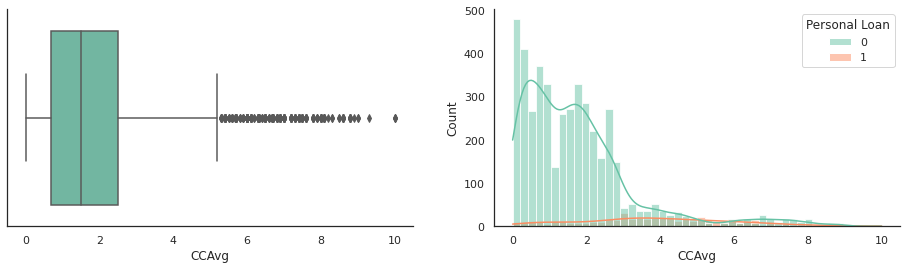

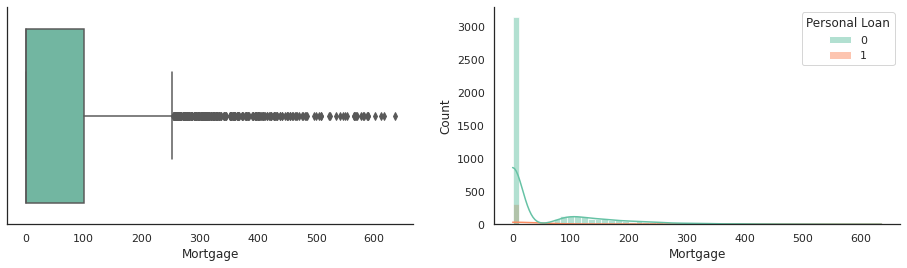

In [110]:
sns.set_palette(sns.color_palette("Set2"))

for c in ['Age', 'Income', 'CCAvg', 'Mortgage']:
  fig, ax = plt.subplots(1, 2, figsize=(16, 4))
  sns.boxplot(x=df[c], ax=ax[0])
  sns.histplot(data=df[[c, 'Personal Loan']], x=df[c], hue='Personal Loan', ax=ax[1], kde=True);
  plt.show()

Признаки `Income`, `CCAvg`, `Mortgage` имеют заметную правостороннюю асимметрию, при этом соответствующее распределение целевого признака `Personal Loan` смещено также вправо.

# Подготовка данных

Сформируем данные для обучения моделей. Выделим целевой признак.

In [111]:
X = df.drop('Personal Loan', axis=1)
Y = df['Personal Loan']

## Кодирование категориальных признаков

Значения категориальных признаков `Education` и `Region` необходимо закодировать.

In [112]:
cat_code_cols = ['Education', 'Region']
X = pd.get_dummies(X, columns=cat_code_cols, drop_first=True)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Age                        4993 non-null   int64   
 1   Income                     4993 non-null   int64   
 2   Family                     4993 non-null   category
 3   CCAvg                      4993 non-null   float64 
 4   Mortgage                   4993 non-null   int64   
 5   Securities Account         4993 non-null   category
 6   CD Account                 4993 non-null   category
 7   Online                     4993 non-null   category
 8   CreditCard                 4993 non-null   category
 9   Education_2                4993 non-null   uint8   
 10  Education_3                4993 non-null   uint8   
 11  Region_Central             4993 non-null   uint8   
 12  Region_Los Angeles Region  4993 non-null   uint8   
 13  Region_Southern            4993 n

## Разделение на обучающую и тестовую выборки

Разделим данные на обучающую и тестовую выборки, выполнив при этом стратификацию данных, что особенно важно при несбалансированных данных.

In [113]:
# определим параметр рандомизации
model_random_state = 100

# разделим данные на тренировочную и тестовую выборки в пропорции 80 / 20
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=model_random_state, stratify=Y)

## Масштабирование данных

In [114]:
# используем стандартный трансформер
scaler = StandardScaler()

# масштабируем обучающую выборку
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку, используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

# Обучение моделей

Для подбора лучшего варианта обучения модели сформируем различные конфигурации классификаторов. Будем использовать следующие методы классификации:
* Логистическая регрессия
* Стохастический градиентный спуск
* Дерево принятия решений

Для каждой конфигурации указываем набор параметров и перечень значений, используемых для подбора наилучшего сочетания.

In [115]:
# логистическая регрессия
def get_pipeline_LR():
    pipeline = Pipeline([
        ('clf', LogisticRegression(random_state=model_random_state, max_iter=1000))
    ])
    parameters = {
        'clf__C': [0.01, 0.1, 1],
        'clf__solver': ['newton-cg', 'liblinear']
    }
    return pipeline, parameters

# стохастический градиентный спуск
def get_pipeline_SGD():
    pipeline = Pipeline([
        ('clf', SGDClassifier(random_state=model_random_state, max_iter=3000))
    ])
    parameters = {
        'clf__loss': ['hinge', 'modified_huber', 'perceptron', 'huber'],
        'clf__n_iter_no_change': [20, 40, 50, 60]
    }
    return pipeline, parameters

# деревья принятия решений
def get_pipeline_DT():
    pipeline = Pipeline([
        ('clf', DecisionTreeClassifier(random_state=model_random_state))
    ])
    parameters = {
        'clf__max_depth': range(2, 9),
        'clf__min_samples_split': range(2, 12, 2),
        'clf__min_samples_leaf': [1, 2, 4, 8, 10, 12],
        'clf__max_features': range(2, 12, 2)
    }
    return pipeline, parameters

Зададим функцию проведения эксперимента:
* выбираем проверяемую конфигурацию и набор параметров
* выполняем перебор параметров классификатора для определения наилучших
* обучаем модель на тренировочной выборке
* тестируем модель на тестовой выборке
* выводим оценку и набор параметров лучшей конфигурации

Для оценки моделей целесообразно использовать метрику recall, поскольку в этом случае удастся уменьшить количество ложноотрицательных результатов, что позволит собрать более широкую базу потенциальных клиентов для кредитного предложения.

In [116]:
def do_experiment(X_train, y_train, X_test, y_test, get_pipeline_and_params):
    # выбираем тестируемую конфигурацию и набор параметров
    pipeline, parameters = get_pipeline_and_params()

    # выполняем перебор для определения наилучших параметров
    # с использованием метрики recall
    grid_search = GridSearchCV(pipeline, parameters, scoring='recall')
    grid_search.fit(X_train, y_train)

    # получаем набор параметров лучшей конфигурации
    best_parameters = {}
    best_estimator_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        best_parameters[param_name] = best_estimator_parameters[param_name]

    # выбираем лучшую модель
    predictor = grid_search.best_estimator_

    # обучаем модель на тренировочной выборке
    predictor.fit(X_train, y_train)

    # тестируем модель
    prediction_test = predictor.predict(X_test)

    # рассчитываем метрики оценки модели
    model_test_metric = [
        metrics.accuracy_score(prediction_test, y_test),
        metrics.recall_score(prediction_test, y_test),
        metrics.precision_score(prediction_test, y_test)
    ]

    # возвращение параметры модели и метрики
    return best_parameters, model_test_metric

# Проведение экспериментов и оценка моделей

Проведем эксперименты для всех заданных конфигураций.

In [117]:
# список экспериментов
experiments = [
    ['Логистическая регрессия', get_pipeline_LR],
    ['Стохастический градиентный спуск', get_pipeline_SGD],
    ['Дерево принятия решений', get_pipeline_DT]
]

model_estim_x = []
model_estim_val = []

for ex in experiments:
    best_parameters, model_test_metric = do_experiment(X_train, y_train, X_test, y_test, ex[1])
    model_estim_x.append(ex[0])
    model_estim_val.append(model_test_metric[1])
    print("Модель:", ex[0])
    print(f"   Accuracy: {model_test_metric[0]:.2f}")
    print(f"  Precision: {model_test_metric[2]:.2f}")
    print(f"     Recall: {model_test_metric[1]:.2f}")
    print("Лучший набор параметров:")
    for param_name in sorted(best_parameters.keys()):
        print(f"\t{param_name.replace('clf__', '')}: {best_parameters[param_name]}")
    print("-" * 30)
    print("")

max_value = max(model_estim_val)
max_index = model_estim_val.index(max_value)

Модель: Логистическая регрессия
   Accuracy: 0.96
  Precision: 0.64
     Recall: 0.94
Лучший набор параметров:
	C: 1
	solver: newton-cg
------------------------------

Модель: Стохастический градиентный спуск
   Accuracy: 0.94
  Precision: 0.42
     Recall: 0.89
Лучший набор параметров:
	loss: hinge
	n_iter_no_change: 50
------------------------------

Модель: Дерево принятия решений
   Accuracy: 0.98
  Precision: 0.81
     Recall: 0.99
Лучший набор параметров:
	max_depth: 8
	max_features: 8
	min_samples_leaf: 1
	min_samples_split: 10
------------------------------



Выведем диаграмму для сравнения значения метрики в каждой из конфигураций.

<BarContainer object of 3 artists>

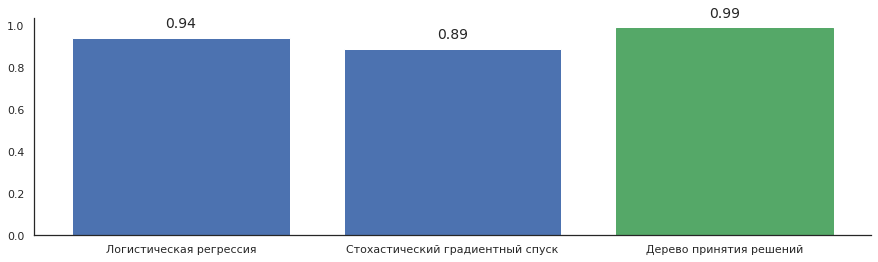

In [118]:
sns.set_palette(sns.color_palette("tab10"))
sns.set_theme(style="white", rc=custom_params)

metrics_bar = plt.bar(model_estim_x, model_estim_val)
metrics_bar[max_index].set_color('g')

for i in range(len(model_estim_x)):
  plt.text(i, model_estim_val[i] + 0.05, round(model_estim_val[i], 2), ha='center', size=14)

metrics_bar

Лучший результат предсказания показала модель на основе дерева принятия решений.